In [200]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [201]:
# Read the CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [202]:
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
testDF = df_encoded
print(df_encoded['diabetes'].value_counts())

diabetes
0    91500
1     8500
Name: count, dtype: int64


In [203]:
testDF = testDF.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
boolean_columns = x_unscaled.select_dtypes(include=bool).columns

scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [204]:
# Load the mlp model
mlp_file = './models/mlp_model_resampled_0.15.keras'
mlp_model = load_model(mlp_file)
print("Model loaded successfully.")

Model loaded successfully.


## Testing the MLP Model

In [205]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming x_scaled and y are already defined

# Make predictions on the entire dataset
y_pred = mlp_model.predict(x_scaled)

# Calculate the Mean Squared Error (MSE) on the entire dataset
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on Entire Dataset: {rmse}')

# Convert y_pred to binary predictions
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Ensure y is a numpy array and reshape if necessary
y_array = y.values if hasattr(y, 'values') else y
if y_array.ndim > 1:
    y_array = y_array.reshape(-1)

# Ensure y_pred_binary is a 1-dimensional array
if y_pred_binary.ndim > 1:
    y_pred_binary = y_pred_binary.reshape(-1)

# Compare y_pred_binary with y
correct_predictions = np.sum(y_pred_binary == y_array)
wrong_predictions = np.sum(y_pred_binary != y_array)

# Track indices of wrong predictions
wrong_prediction_indices = np.where(y_pred_binary != y_array)[0]

# Calculate additional metrics
true_positives = np.sum((y_pred_binary == 1) & (y_array == 1))
true_negatives = np.sum((y_pred_binary == 0) & (y_array == 0))
false_positives = np.sum((y_pred_binary == 1) & (y_array == 0))
false_negatives = np.sum((y_pred_binary == 0) & (y_array == 1))

print(f"Number of Correct Predictions: {correct_predictions}")
print(f"Number of Wrong Predictions: {wrong_predictions}")
print(f"Number of True Positives (1 predicted as 1): {true_positives}")
print(f"Number of True Negatives (0 predicted as 0): {true_negatives}")
print(f"Number of False Positives (0 predicted as 1): {false_positives}")
print(f"Number of False Negatives (1 predicted as 0): {false_negatives}")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error on Entire Dataset: 0.17549384931959422
Number of Correct Predictions: 96303
Number of Wrong Predictions: 3697
Number of True Positives (1 predicted as 1): 6117
Number of True Negatives (0 predicted as 0): 90186
Number of False Positives (0 predicted as 1): 1314
Number of False Negatives (1 predicted as 0): 2383


In [206]:
print("Indices of Wrong Predictions:", wrong_prediction_indices)

Indices of Wrong Predictions: [    4    17    82 ... 99957 99978 99994]


## Testing the autoencoder model

In [207]:
# Load the autoencoder model
autoencoder_file = './models/autoencoder.keras'
autoencoder_model = load_model(autoencoder_file)
print("Autoencoder model loaded successfully.")

Autoencoder model loaded successfully.


c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Mean Reconstruction Error Percentage: 27.635432614904843%


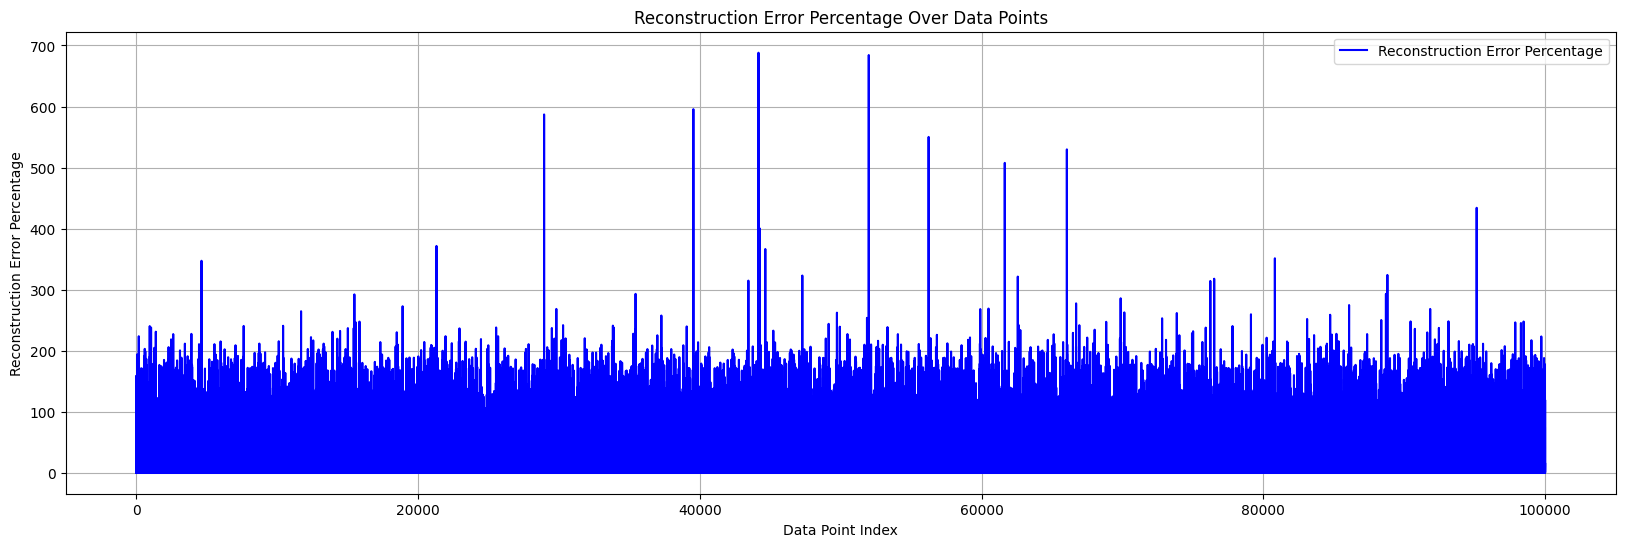

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate reconstruction error for the entire dataset
reconstructed_data = autoencoder_model.predict(x_scaled)
reconstruction_error = np.mean(np.square(x_scaled - reconstructed_data), axis=1)

# Calculate the reconstruction error percentage
reconstruction_error_percentage = reconstruction_error * 100
mean_reconstruction_error_percentage = np.mean(reconstruction_error_percentage)
print(f'Mean Reconstruction Error Percentage: {mean_reconstruction_error_percentage}%')

# Collect indices where reconstruction error percentage is over 50%
high_error_indices = np.where(reconstruction_error_percentage > 50)[0]

# Plot the reconstruction error percentage over data points
plt.figure(figsize=(20, 6))
plt.plot(reconstruction_error_percentage, linestyle='-', color='b', label='Reconstruction Error Percentage')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error Percentage')
plt.title('Reconstruction Error Percentage Over Data Points')
plt.legend()
plt.grid(True)
plt.show()

In [209]:
# Print indices of high reconstruction error
print(f"Indices with Reconstruction Error Percentage over 50%: {high_error_indices}")

Indices with Reconstruction Error Percentage over 50%: [    1     2    14 ... 99983 99992 99994]


In [210]:
print("Number of High Reconstruction Error Points (greater than 50%):", len(high_error_indices))

Number of High Reconstruction Error Points (greater than 50%): 15645


Number of Common Indices: 867
Correlation Percentage: 23.45%


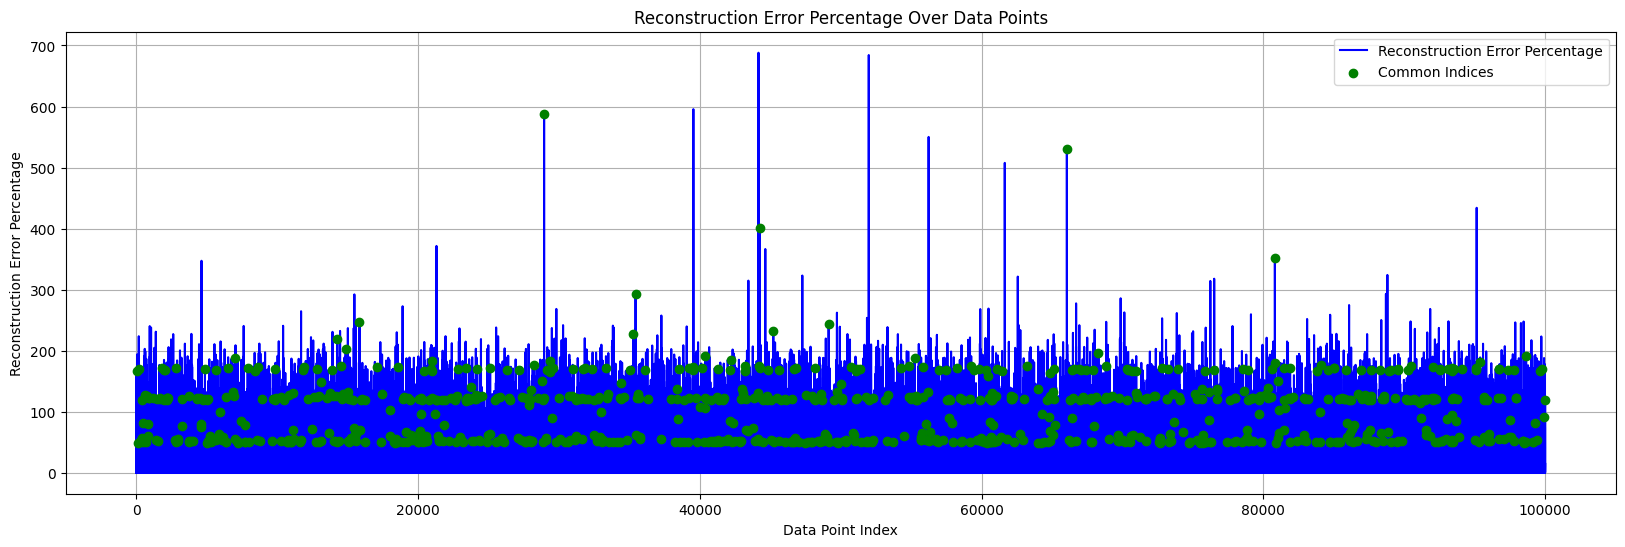

In [211]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming wrong_prediction_indices and high_error_indices are already defined

# Analyze correlation between wrong_prediction_indices and high_error_indices
common_indices = np.intersect1d(wrong_prediction_indices, high_error_indices)
correlation_percentage = (len(common_indices) / len(wrong_prediction_indices)) * 100

print(f"Number of Common Indices: {len(common_indices)}")
print(f"Correlation Percentage: {correlation_percentage:.2f}%")

# Plot the reconstruction error percentage over data points
plt.figure(figsize=(20, 6))
plt.plot(reconstruction_error_percentage, linestyle='-', color='b', label='Reconstruction Error Percentage')

# Highlight common points
plt.scatter(common_indices, reconstruction_error_percentage[common_indices], color='g', label='Common Indices', zorder=6)

plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error Percentage')
plt.title('Reconstruction Error Percentage Over Data Points')
plt.legend()
plt.grid(True)
plt.show()

Filtered Data (Common Indices):
      age  hypertension  heart_disease    bmi  HbA1c_level  \
82   65.0             1              1  33.50          6.1   
102  34.0             1              0  27.32          6.1   
192  68.0             1              1  32.17          6.0   
325  77.0             1              0  28.07          6.6   
423  68.0             1              0  40.29          6.2   

     blood_glucose_level  diabetes  gender_Male  gender_Other  \
82                   160         1         True         False   
102                  145         1        False         False   
192                  200         0        False         False   
325                  200         0         True         False   
423                  200         0        False         False   

     smoking_history_current  smoking_history_ever  smoking_history_former  \
82                     False                 False                    True   
102                    False                 Fal

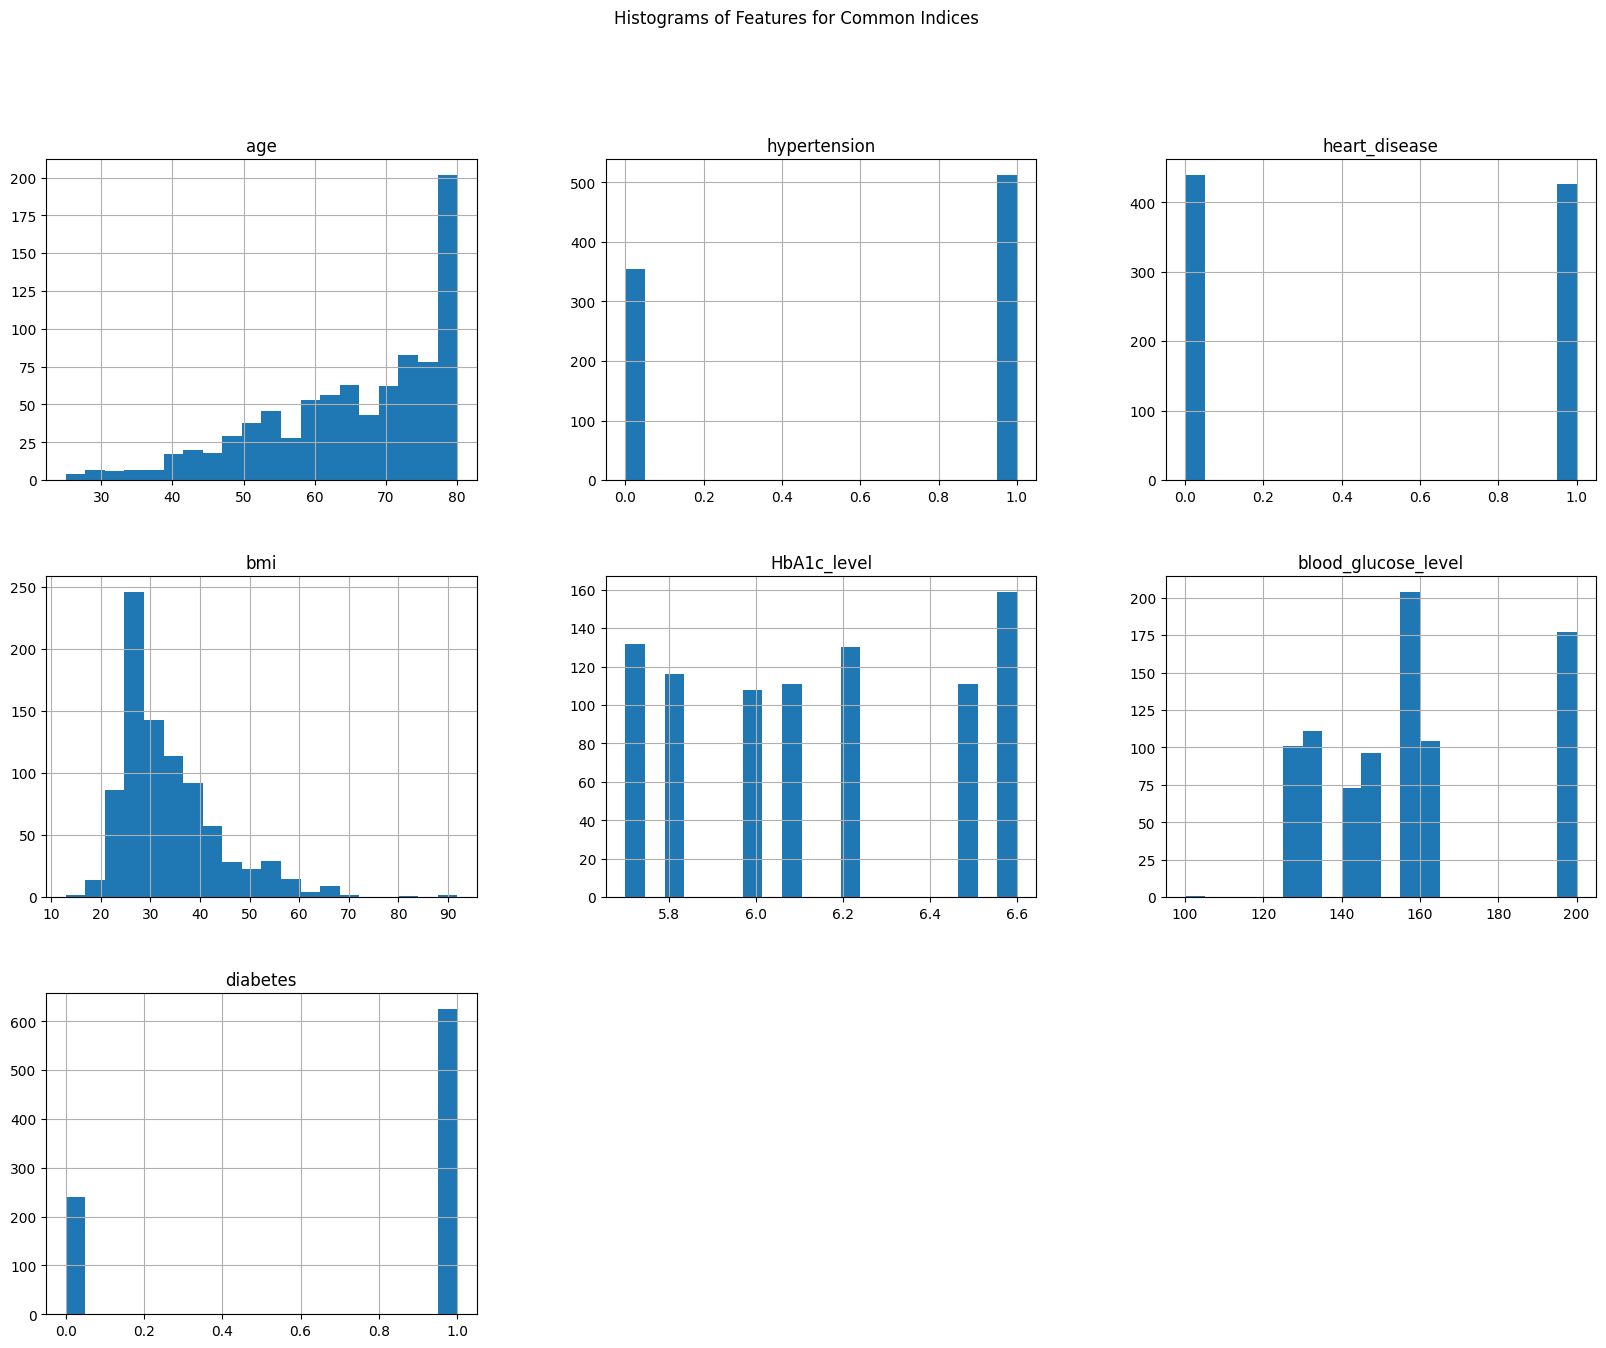

c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


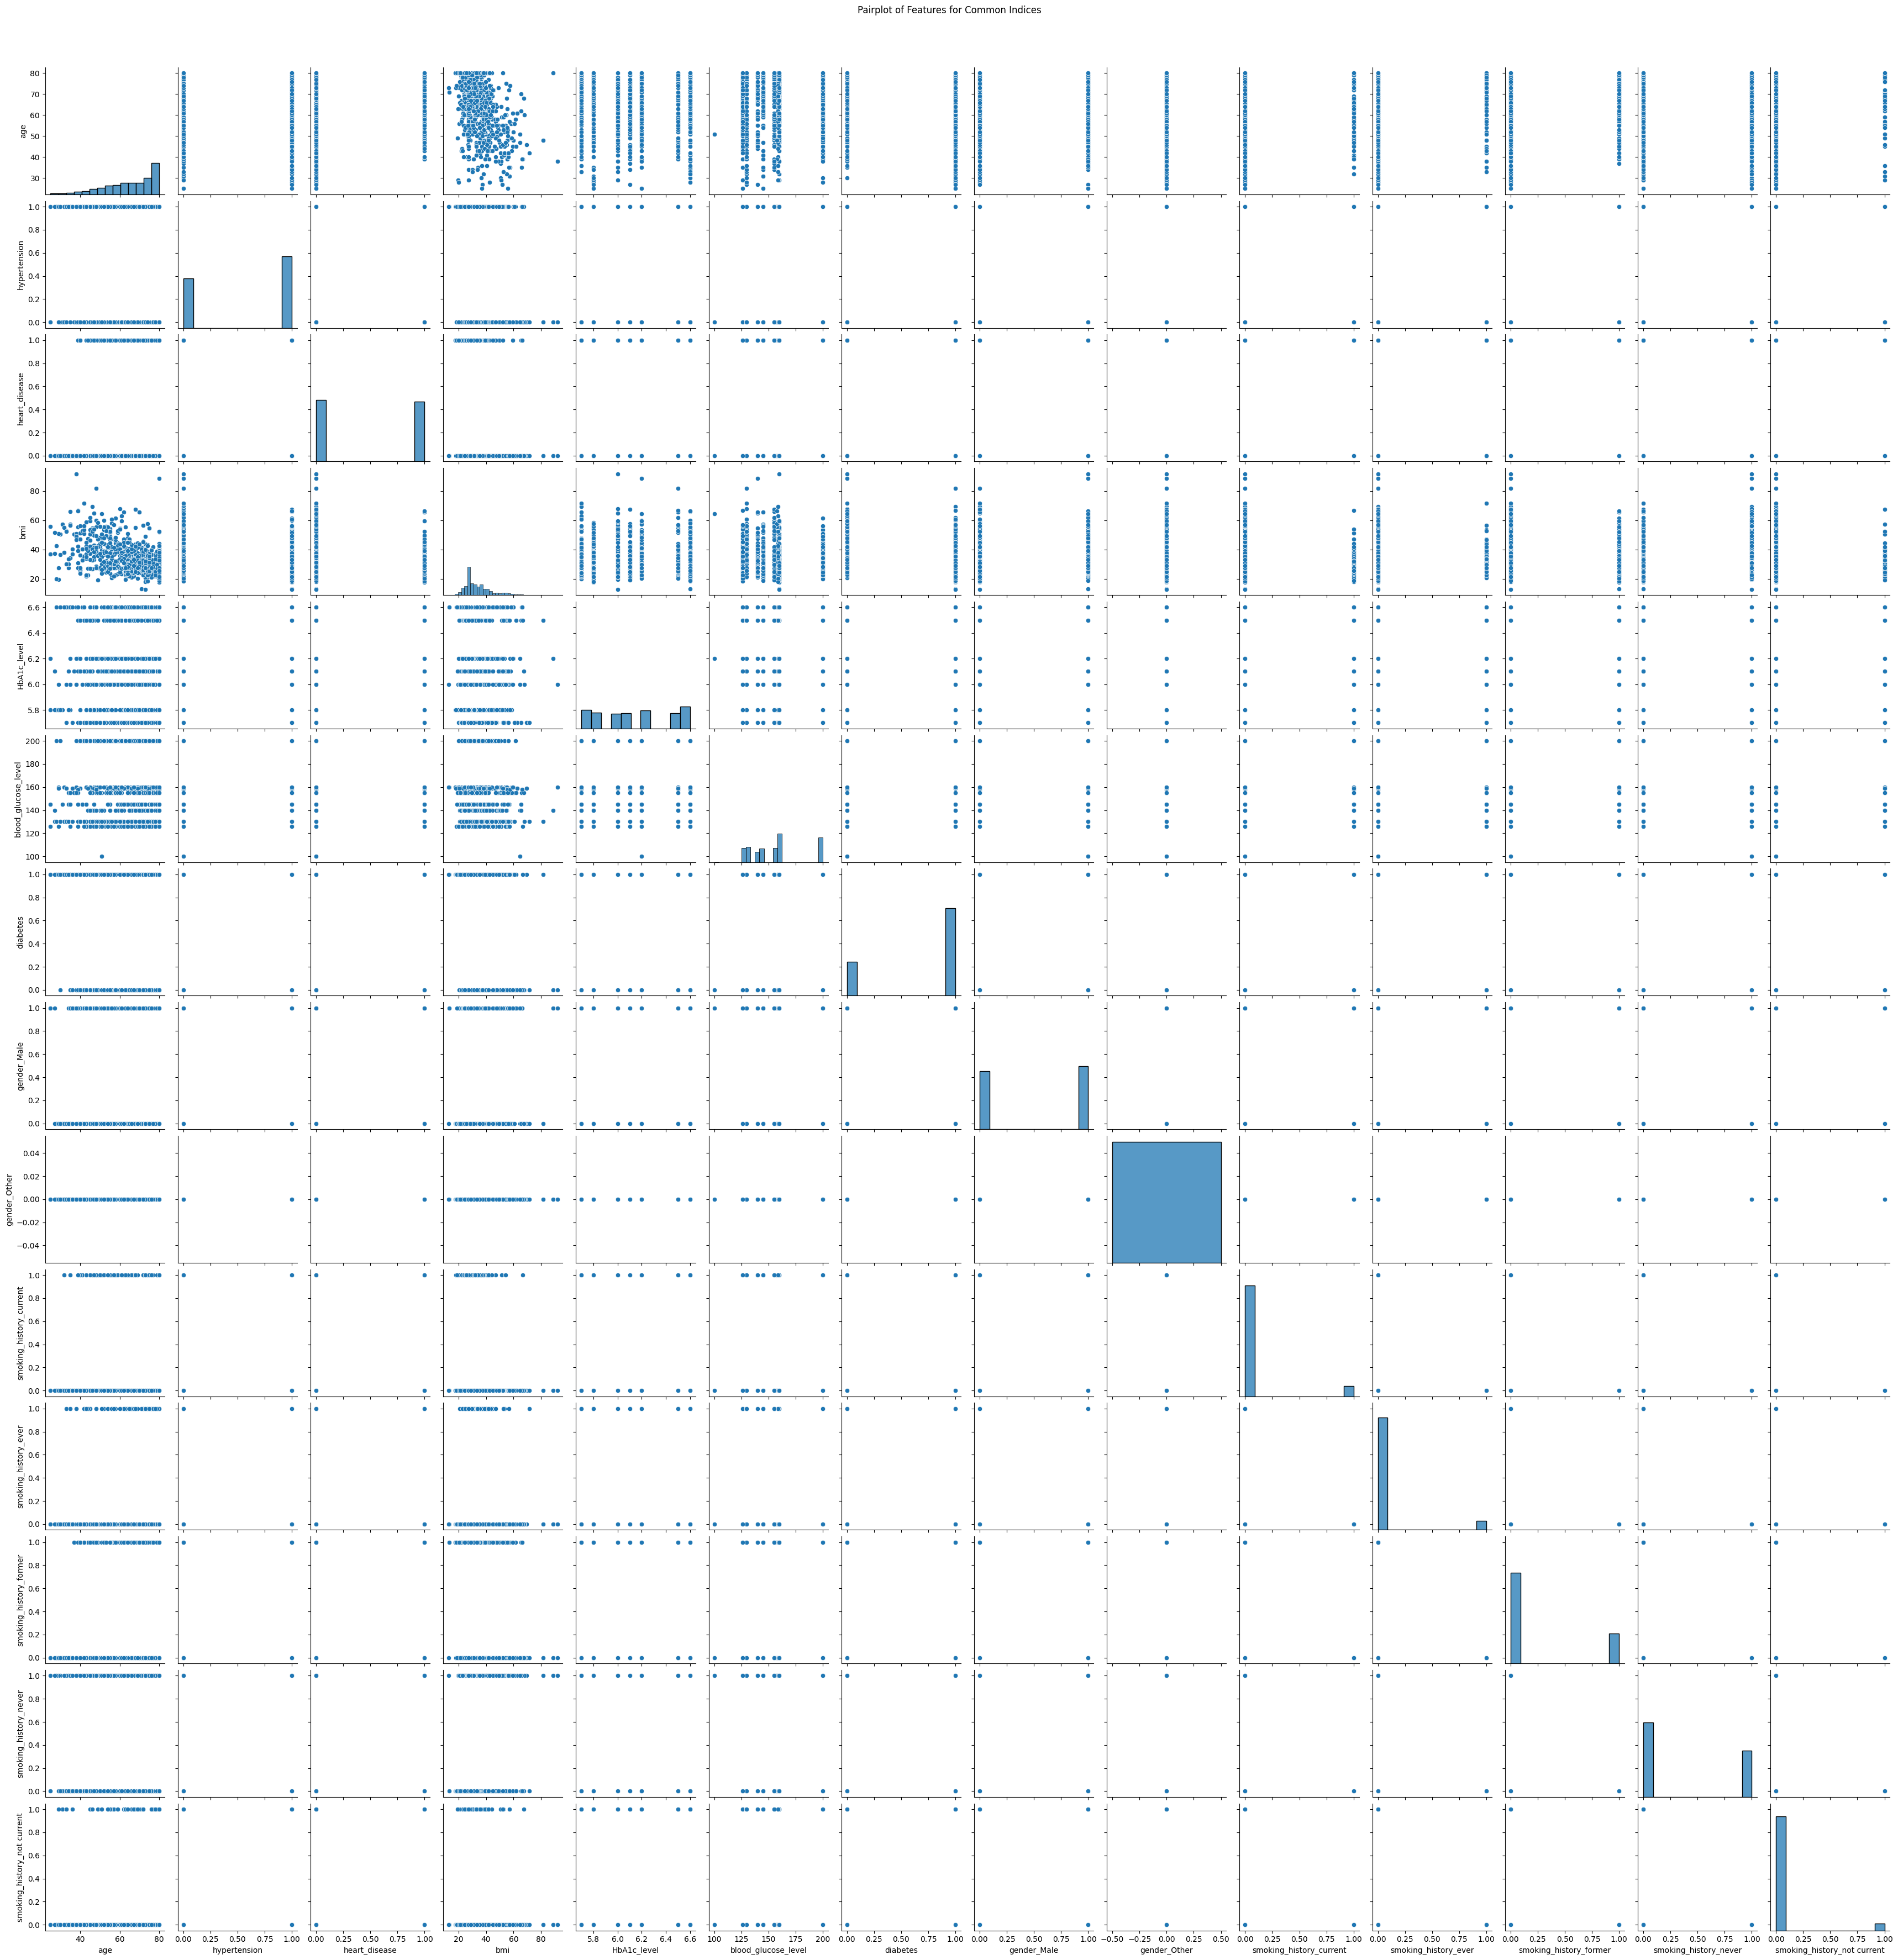

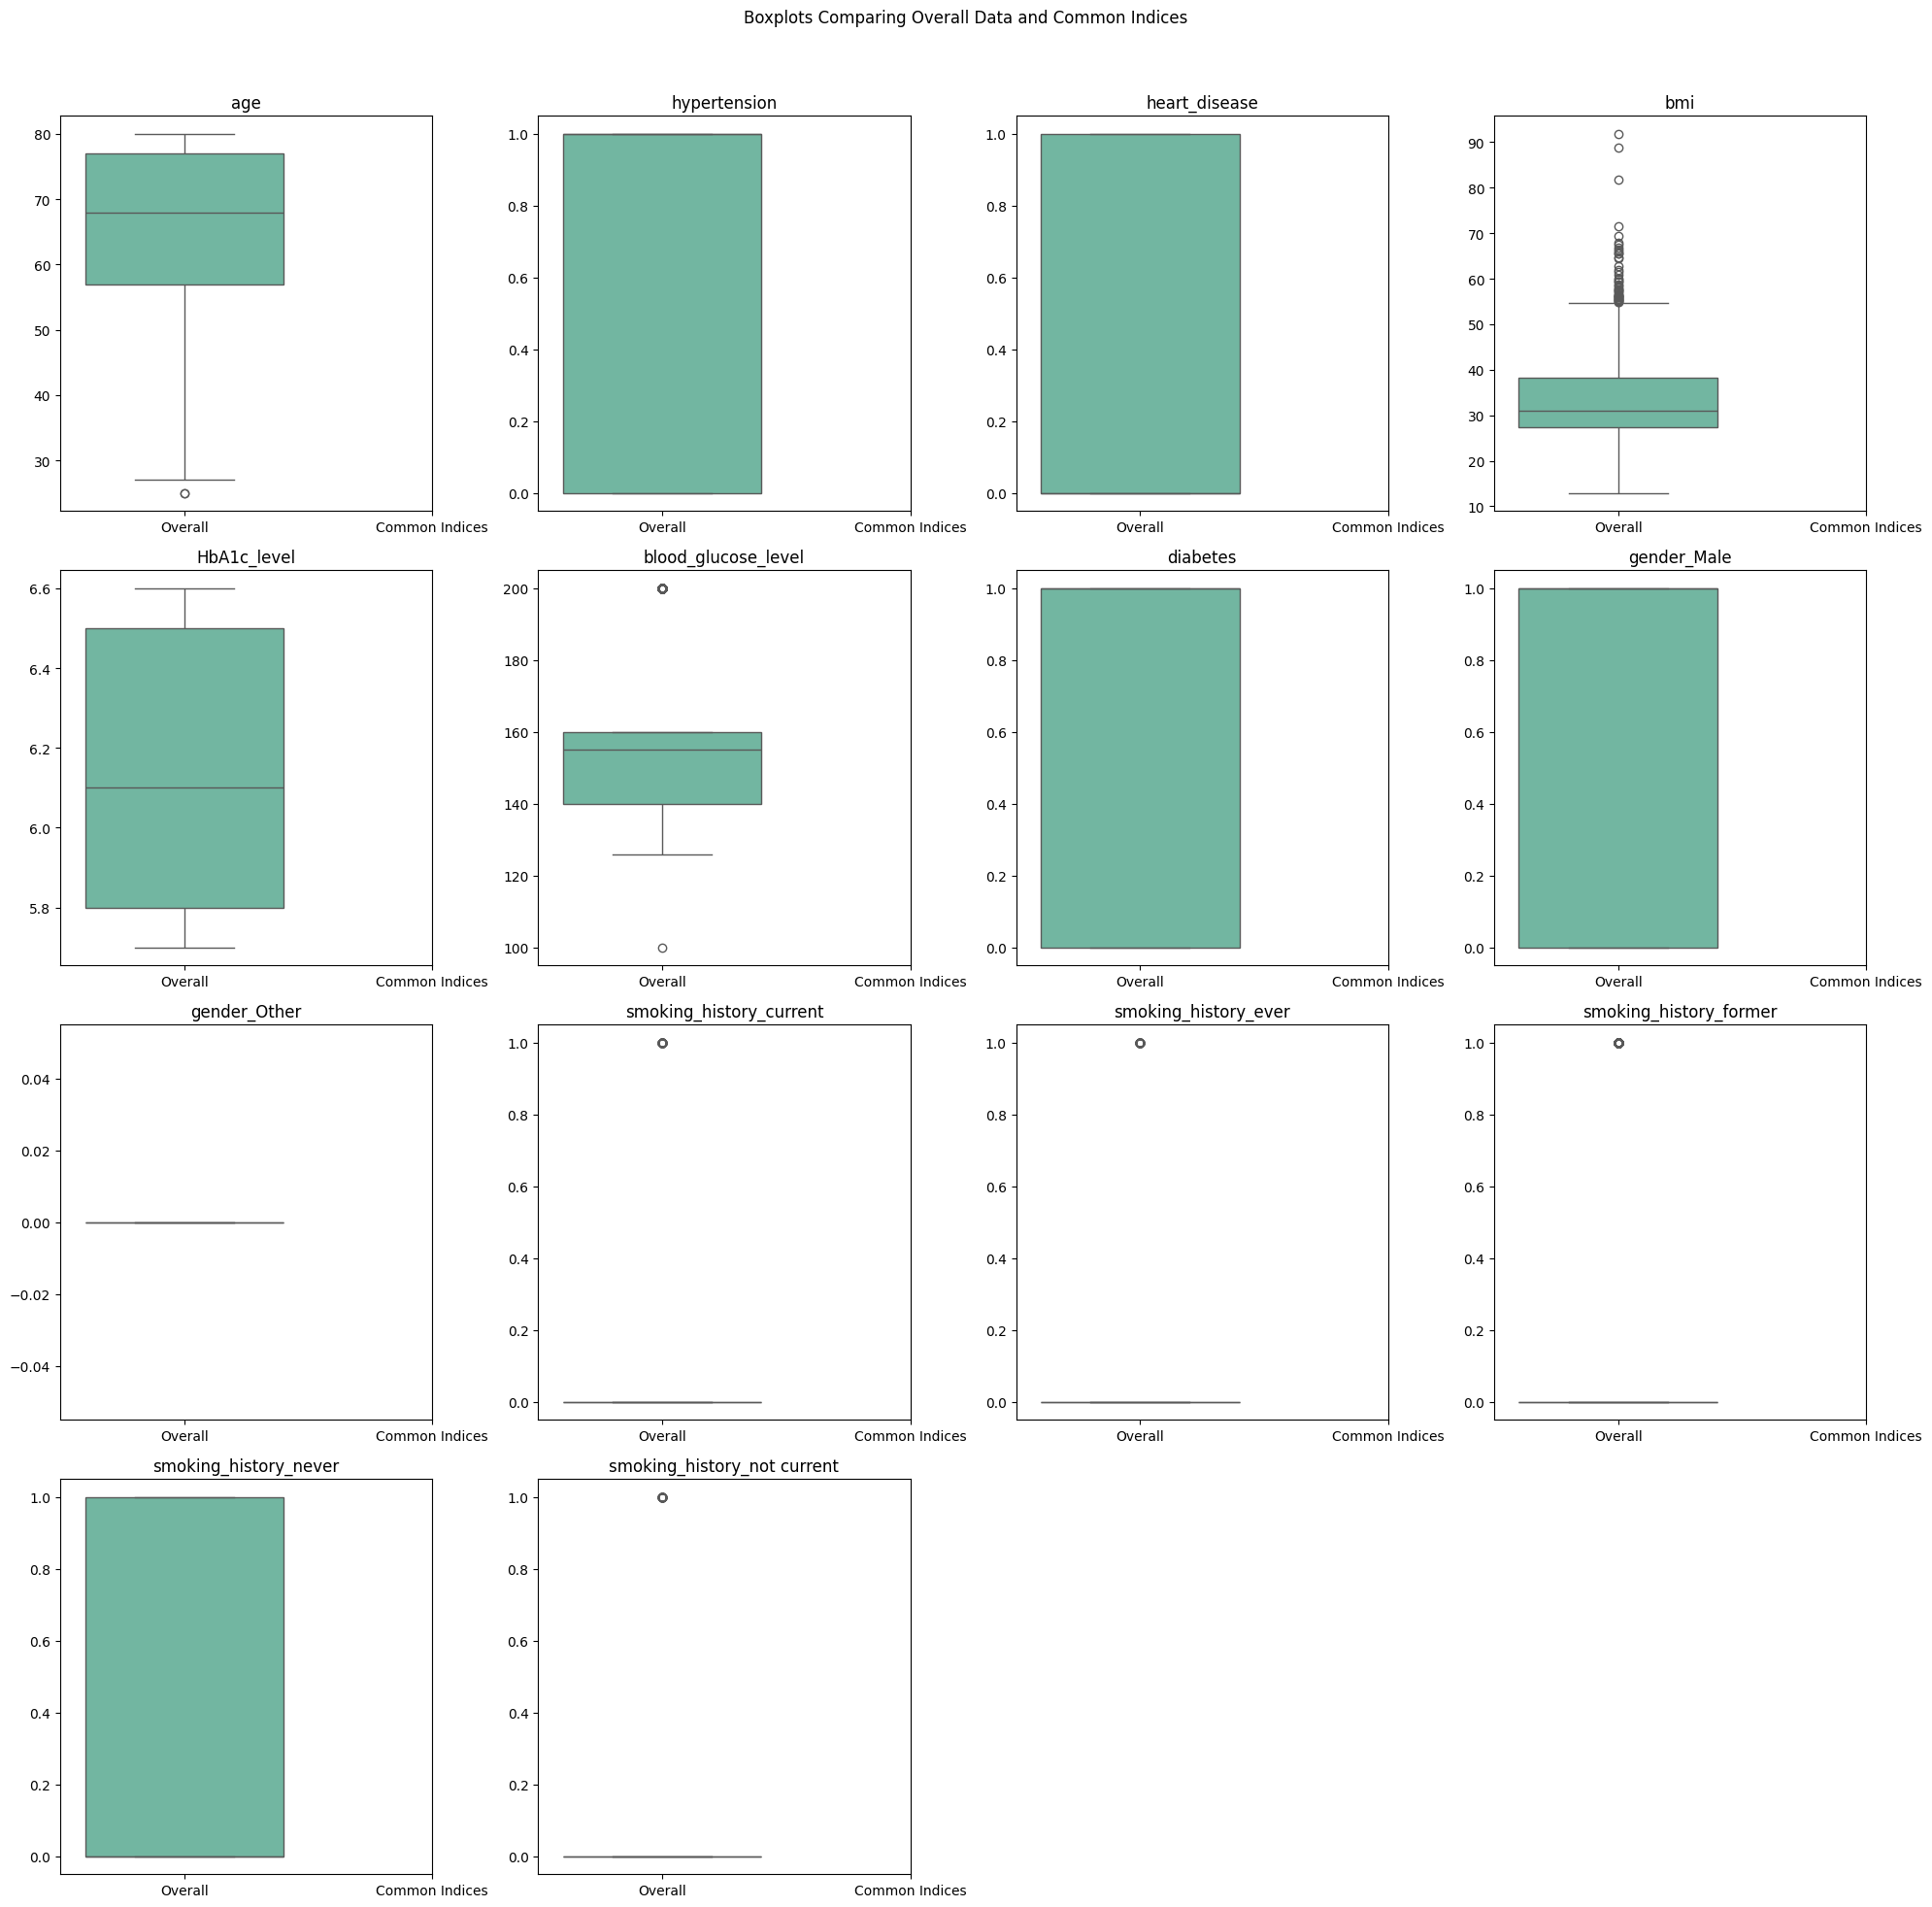

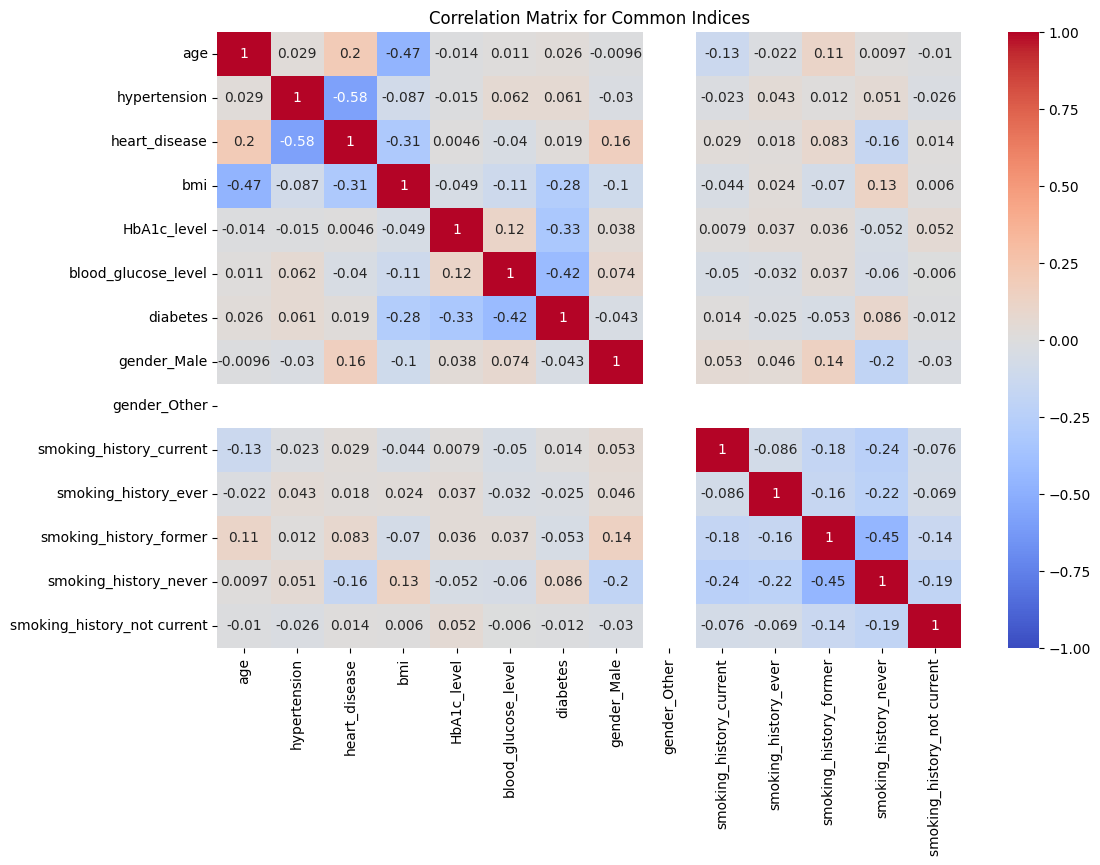

In [212]:
# Assuming common_indices and testDF are already defined

# Filter the DataFrame to get the rows corresponding to the common indices
common_data = testDF.iloc[common_indices]

# Display the first few rows of the filtered data
print("Filtered Data (Common Indices):")
print(common_data.head())

# Summary statistics for the filtered data
summary_stats = common_data.describe(include='all')
print("\nSummary Statistics for Common Indices:")
print(summary_stats)

# Identify categorical columns
categorical_columns = common_data.select_dtypes(include=['object', 'category']).columns

# Convert categorical columns to numerical values for visualization purposes
common_data_encoded = common_data.copy()
testDF_encoded = testDF.copy()

for col in categorical_columns:
    common_data_encoded[col] = common_data_encoded[col].astype('category').cat.codes
    testDF_encoded[col] = testDF_encoded[col].astype('category').cat.codes

# Visualizations

# Histogram for each feature in the filtered data
common_data_encoded.hist(bins=20, figsize=(20, 15))
plt.suptitle('Histograms of Features for Common Indices')
plt.show()

# Pairplot to visualize relationships between features (excluding categorical columns)
sns.pairplot(common_data_encoded.drop(columns=categorical_columns))
plt.suptitle('Pairplot of Features for Common Indices', y=1.02)
plt.show()

# Boxplot to compare distributions of features in the filtered data vs overall data
num_columns = len(testDF_encoded.columns)
num_rows = (num_columns // 4) + 1

plt.figure(figsize=(20, num_rows * 5))
for i, column in enumerate(testDF_encoded.columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.boxplot(data=[testDF_encoded[column], common_data_encoded[column]], palette="Set2")
    plt.title(column)
    plt.xticks([0, 1], ['Overall', 'Common Indices'])
plt.suptitle('Boxplots Comparing Overall Data and Common Indices')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Correlation matrix for the filtered data (excluding categorical columns)
correlation_matrix = common_data_encoded.drop(columns=categorical_columns).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Common Indices')
plt.show()

In [213]:
testDF.shape

(100000, 14)